**DHS in-country cross-validated model results.**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Load-Saved-Data" data-toc-modified-id="Load-Saved-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Saved Data</a></span><ul class="toc-item"><li><span><a href="#Load-labels,-locs,-and-years" data-toc-modified-id="Load-labels,-locs,-and-years-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load <code>labels</code>, <code>locs</code>, and <code>years</code></a></span></li><li><span><a href="#Load-loc_dict" data-toc-modified-id="Load-loc_dict-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load <code>loc_dict</code></a></span></li><li><span><a href="#Get-urban-v.-rural-indices" data-toc-modified-id="Get-urban-v.-rural-indices-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Get urban v. rural indices</a></span></li><li><span><a href="#country_indices-and-country_labels" data-toc-modified-id="country_indices-and-country_labels-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span><code>country_indices</code> and <code>country_labels</code></a></span></li></ul></li><li><span><a href="#Load-saved-preds" data-toc-modified-id="Load-saved-preds-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load saved preds</a></span><ul class="toc-item"><li><span><a href="#Create-CSV-of-all-preds" data-toc-modified-id="Create-CSV-of-all-preds-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create CSV of all preds</a></span></li></ul></li><li><span><a href="#Overall-MSE,-$R^2$,-$r^2$,-rank-corr" data-toc-modified-id="Overall-MSE,-$R^2$,-$r^2$,-rank-corr-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Overall MSE, $R^2$, $r^2$, rank-corr</a></span><ul class="toc-item"><li><span><a href="#Individual-model-results" data-toc-modified-id="Individual-model-results-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Individual model results</a></span></li><li><span><a href="#Model-Similarity-Heatmaps" data-toc-modified-id="Model-Similarity-Heatmaps-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Model Similarity Heatmaps</a></span></li><li><span><a href="#Cumulative-analysis" data-toc-modified-id="Cumulative-analysis-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Cumulative analysis</a></span></li></ul></li><li><span><a href="#Break-down-by-country,-urban/rural" data-toc-modified-id="Break-down-by-country,-urban/rural-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Break-down by country, urban/rural</a></span></li><li><span><a href="#$r^2$-over-all-countries" data-toc-modified-id="$r^2$-over-all-countries-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>$r^2$ over all countries</a></span></li><li><span><a href="#Break-down-by-country-year,-urban/rural" data-toc-modified-id="Break-down-by-country-year,-urban/rural-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Break-down by country-year, urban/rural</a></span></li><li><span><a href="#Urban/rural" data-toc-modified-id="Urban/rural-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Urban/rural</a></span><ul class="toc-item"><li><span><a href="#By-Country" data-toc-modified-id="By-Country-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>By Country</a></span></li></ul></li><li><span><a href="#Model-performance-as-function-of-NL" data-toc-modified-id="Model-performance-as-function-of-NL-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Model performance as function of NL</a></span><ul class="toc-item"><li><span><a href="#When-NL-=-0" data-toc-modified-id="When-NL-=-0-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>When NL = 0</a></span></li><li><span><a href="#Predictions-vs.-NL-mean" data-toc-modified-id="Predictions-vs.-NL-mean-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Predictions vs. NL mean</a></span></li></ul></li></ul></div>

# Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import defaultdict
import itertools
import pickle
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('../')
from batchers import dataset_constants1996
from utils.analysis import (
    calc_score,
    chunk_vs_score,
    evaluate_df,
    plot_chunk_vs_score,
    plot_label_vs_score,
    plot_percdata_vs_score,
    sorted_scores)
from utils.general import colordisplay, load_npz
from utils.plot import scatter_preds, symmetric_heatmap

In [25]:
LOGS_ROOT_DIR = '/home/abenabbes/africapoverty/'
DATASET_NAME = 'DHS-ALL'

MODEL_NAME_TO_DIR = {
    # KNN
    'KNN NL mean scalar': '../checkpoints/BASELINES/dhs_knn/incountry_nlmean_scalar',
    'KNN NL center scalar': '../checkpoints/BASELINES/dhs_knn/incountry_nlcenter_scalar',
    'KNN NL hist': '../checkpoints/BASELINES/dhs_knn/incountry_nl_hist',

    # GBT
    'GBT NL mean scalar': '../checkpoints/BASELINES/dhs_gbt/nls_mean',
    'GBT NL mean scalar': '../checkpoints/BASELINES/dhs_gbt/nls_mean',

    # Ridge
    'Ridge NL mean scalar': '../checkpoints/BASELINES/dhs_ridge/incountry_nlmean_scalar',
    'Ridge NL center scalar': '../checkpoints/BASELINES/dhs_ridge/incountry_nlcenter_scalar',
    'Ridge RGB hist': '../checkpoints/BASELINES/dhs_ridge/incountry_rgb_hist',
    'Ridge MS hist': '../checkpoints/BASELINES/dhs_ridge/incountry_ms_hist',
    'Ridge NL hist': '../checkpoints/BASELINES/dhs_ridge/incountry_nl_hist',
    'Ridge RGB+NL hist': '../checkpoints/BASELINES/dhs_ridge/incountry_rgbnl_hist',
    'Ridge MS+NL hist': '../checkpoints/BASELINES/dhs_ridge/incountry_msnl_hist',

     #Resnet
    'Resnet-18 MS': '../checkpoints/DHS_Incountry/resnet_ms',
    'Resnet-18 MS+NL concat': '../checkpoints/DHS_Incountry/resnet_rgbnl_concat',
    'Resnet-18 NL': '../checkpoints/DHS_Incountry/resnet_nl',
    'Resnet-18 RGB': '../checkpoints/DHS_Incountry/resnet_rgb',
    'Resnet-18 RGBNL': '../checkpoints/DHS_Incountry/resnet_rgbnl_concat',    

}

MODEL_NAMES = sorted(MODEL_NAME_TO_DIR.keys())

# Load Saved Data

## Load `labels`, `locs`, and `years`

In [4]:
countries=["angola", "benin", "burkina_faso", "cameroon", "cote_d_ivoire",
        "democratic_republic_of_congo", "ethiopia", "ghana", "guinea", "kenya",
        "lesotho", "malawi", "mali", 
        "mozambique", "nigeria", "madagascar",
        "rwanda", "senegal", "sierra_leone",
        "tanzania", "togo", "uganda", "zambia", "zimbabwe", "comores"]

In [6]:

npz = load_npz('../checkpoints/dhs_image_hists.npz')


labels = npz['labels']
locs = npz['locs']
years = npz['years']
nls_center = npz['nls_center']
nls_mean = npz['nls_mean']

num_examples = len(labels)
assert np.all(np.asarray([len(labels), len(locs), len(years), len(nls_center), len(nls_mean)]) == num_examples)
print(labels)


image_hists: dtype=int64, shape=(36424, 8, 102)
labels: dtype=float32, shape=(36424,)
locs: dtype=float32, shape=(36424, 2)
years: dtype=int32, shape=(36424,)
nls_center: dtype=float32, shape=(36424,)
nls_mean: dtype=float32, shape=(36424,)
[ 2.3127568   2.010293    0.87774396 ... -0.26969486  1.3907564
 -0.016828  ]


## Load `loc_dict`

`loc_dict` has the format:
```python
{
    (lat, lon): {
        'cluster': 1,
        'country': 'malawi',
        'country_year': 'malawi_2012',  # surveyID
        'households': 25,
        'urban': False,
        'wealth': -0.513607621192932,
        'wealthpooled': -0.732255101203918,
        'year': 2012
    }, ...
}
```

NOTE: `year` and `country_year` might differ in the year. `country_year` is the survey ID, which says which year the survey started. However, sometimes the DHS surveys cross the year-boundary, in which case `country_year` will remain the same but `year` will be the next year.

In [8]:
loc_dict_path = '../checkpoints/loc_dict.pkl'
with open(loc_dict_path, 'rb') as f:
    loc_dict = pickle.load(f)

## Get urban v. rural indices

In [9]:
def get_urban_rural_indices(locs, loc_dict):
    '''
    Args
    - locs: np.array, shape [N, 2]
    - loc_dict: dict, (lat, lon) => dict

    Returns
    - urban_indices: np.array, shape [num_urban]
    - rural_indices: np.array, shape [num_rural]
    '''
    urban_indices = []
    rural_indices = []

    for i, loc in enumerate(locs):
        loc = tuple(loc)
        if loc_dict[loc]['urban'] == 0:
            rural_indices.append(i)
        else:
            urban_indices.append(i)
    urban_indices = np.asarray(urban_indices)
    rural_indices = np.asarray(rural_indices)
    print(f'num urban: {len(urban_indices)}\t num rural: {len(rural_indices)}')
    return urban_indices, rural_indices

urban_indices, rural_indices = get_urban_rural_indices(locs, loc_dict)

num urban: 12860	 num rural: 23564


## `country_indices` and `country_labels`

`country_indices` is a dictionary that maps a country name to a sorted `np.array` of its indices
```python
{ 'malawi': np.array([ 8530,  8531,  8532, ..., 10484, 10485, 10486]), ... }
```

`country_labels` is a `np.array` that shows which country each example belongs to
```python
np.array([0, 0, 0, 0, ..., 22, 22, 22])
```
where countries are indexed by their position in `dataset_constants.DHS_COUNTRIES`

In [10]:
country_indices = defaultdict(list)  # country => np.array of indices
country_labels = np.zeros(num_examples, dtype=np.int32)  # np.array of country labels

for i, loc in enumerate(locs):
    country = loc_dict[tuple(loc)]['country']
    country_indices[country].append(i)

for i, country in enumerate(countries):
    country_indices[country] = np.asarray(country_indices[country])
    print(country_indices[country])
    indices = country_indices[country]
    country_labels[indices] = i

country_indices['overall'] = np.arange(num_examples)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

# Load saved preds

In [26]:
preds = {}

for model_name, model_dir in MODEL_NAME_TO_DIR.items():
    print(model_name)
    npz_path = os.path.join(LOGS_ROOT_DIR, model_dir, 'test_preds.npz')
    preds[model_name] = load_npz(npz_path)['test_preds']

Resnet-18 MS
labels: dtype=float32, shape=(36424,)
test_preds: dtype=float32, shape=(36424,)
Resnet-18 MS+NL concat
labels: dtype=float32, shape=(36424,)
test_preds: dtype=float32, shape=(36424,)
Resnet-18 NL
labels: dtype=float32, shape=(36424,)
test_preds: dtype=float32, shape=(36424,)


## Create CSV of all preds

In [27]:
preds_df = pd.DataFrame(
    columns=['lat', 'lon', 'country', 'year', 'urban', 'label'] + MODEL_NAMES)
preds_df['lat'] = locs[:, 0]
preds_df['lon'] = locs[:, 1]
preds_df['label'] = labels
preds_df['year'] = years
preds_df['country'] = np.asarray(countries)[country_labels]
preds_df.loc[:, 'urban'] = False
preds_df.loc[urban_indices, 'urban'] = True

for model_name in MODEL_NAMES:
    print(model_name)
    preds_df[model_name] = preds[model_name]

preds_df.to_csv('dhs_incountry_preds_temp.csv', index=False) #for personal checking



Resnet-18 MS
Resnet-18 MS+NL concat
Resnet-18 NL


In [ ]:
## DISPLAY THE PREDICTION OF EACH MODEL

with pd.option_context('display.max_rows', 20):
    display(preds_df)

preds_df.to_csv('dhs_incountry_preds_temp.csv')#for personal checking


,lat,lon,country,year,urban,label,Resnet-18 MS,Resnet-18 MS+NL concat,Resnet-18 NL
0,-12.350257,13.534922,angola,2011,True,2.312757,0.840962,1.039710,1.177616
1,-12.360865,13.551494,angola,2011,True,2.010293,1.156113,1.236197,1.201306
2,-12.613421,13.413085,angola,2011,True,0.877744,1.361707,1.554000,1.225389
3,-12.581454,13.397711,angola,2011,True,1.066994,1.663322,1.663773,1.253074
4,-12.578135,13.418748,angola,2011,True,1.750153,1.438051,1.494934,1.254911
...,...,...,...,...,...,...,...,...,...
36419,-17.915289,31.156115,zimbabwe,2015,True,0.163265,0.970777,0.898934,0.803691
36420,-18.379501,31.872288,zimbabwe,2015,False,0.309562,-0.497334,-0.436031,-0.299132
36421,-16.660612,29.850649,zimbabwe,2015,False,-0.269695,-0.536696,-0.547103,-0.483720
36422,-17.914251,30.956976,zimbabwe,2015,True,1.390756,0.957175,1.088000,1.287867


# Overall MSE, $R^2$, $r^2$, rank-corr

## Individual model results

In [30]:
overall_df = evaluate_df(preds_df, cols=MODEL_NAMES)
overall_df.sort_values(by='r2', ascending=False, inplace=True)
display(overall_df)
#overall_df.to_csv('/performance.csv')


,r2,R2,mse,rank
Resnet-18 MS+NL concat,0.689540,0.689372,0.212855,0.798120
Resnet-18 NL,0.650475,0.650296,0.239632,0.750653
Resnet-18 MS,0.648790,0.648302,0.240998,0.767988


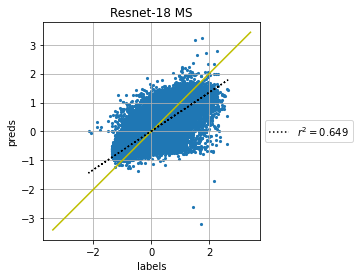

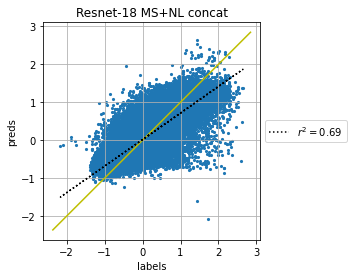

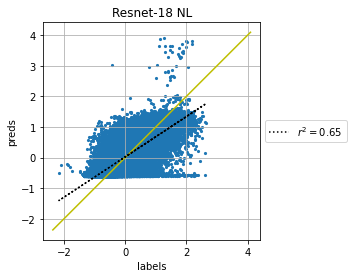

In [31]:
for model_name in MODEL_NAMES:
    model_preds = preds[model_name]
    scatter_preds(
        labels=labels,
        preds=model_preds,
        title=model_name,
        figsize=(4, 4))

## Model Similarity Heatmaps

In [35]:
model_names_by_mse = overall_df.sort_values(by='mse').index
print(model_names_by_mse)
num_models = len(preds)

r2_mat = np.eye(num_models, dtype=np.float64)
rank_mat = np.eye(num_models, dtype=np.float64)

for i, j in itertools.combinations(range(num_models), r=2):
    model_name1 = model_names_by_mse[i]
    model_name2 = model_names_by_mse[j]

    m1_preds = preds[model_name1]
    m2_preds = preds[model_name2]

    r2_mat[i, j] = calc_score(m1_preds, m2_preds, metric='r2')
    rank_mat[i, j] = calc_score(m1_preds, m2_preds, metric='rank')
    r2_mat[j, i] = r2_mat[i, j]
    rank_mat[j, i] = rank_mat[i, j]

Index(['Resnet-18 MS+NL concat', 'Resnet-18 NL', 'Resnet-18 MS'], dtype='object')


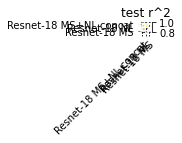

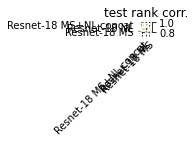

In [36]:
symmetric_heatmap(r2_mat, labels=model_names_by_mse, format_spec='{:.2f}', title='test r^2')
symmetric_heatmap(rank_mat, labels=model_names_by_mse, format_spec='{:.2f}', title='test rank corr.')

## Cumulative analysis

In [37]:
ridge_model_indices, ridge_model_names = [], []
resnet_model_indices, resnet_model_names = [], []

for i, model_name in enumerate(model_names_by_mse):
    if 'Resnet' not in model_name:
        ridge_model_indices.append(i)
        ridge_model_names.append(model_name)
    elif 'Resnet' in model_name:
        resnet_model_indices.append(i)
        resnet_model_names.append(model_name)

TypeError: no numeric data to plot

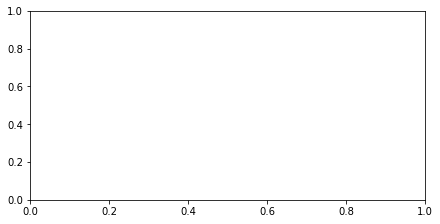

In [38]:
chunk_r2s = np.zeros([len(model_names_by_mse), 5])
for i, model_name in enumerate(model_names_by_mse):
    chunk_r2s[i, :] = chunk_vs_score(preds=preds[model_name], labels=labels, nchunks=5, metric='r2')

plot_chunk_vs_score(scores=chunk_r2s[ridge_model_indices], figsize=(6, 3),
                    legends=ridge_model_names, metric='r2')

plot_chunk_vs_score(scores=chunk_r2s[resnet_model_indices], figsize=(6, 3),
                    legends=resnet_model_names, metric='r2')

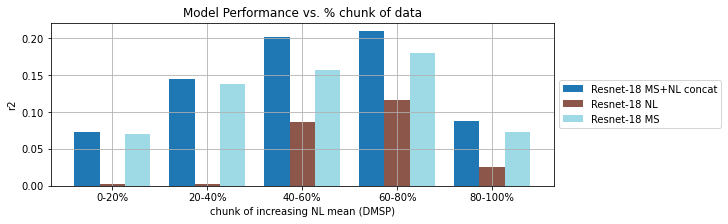

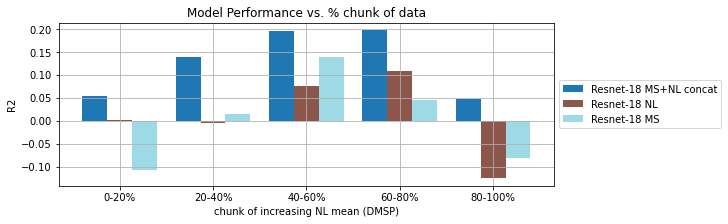

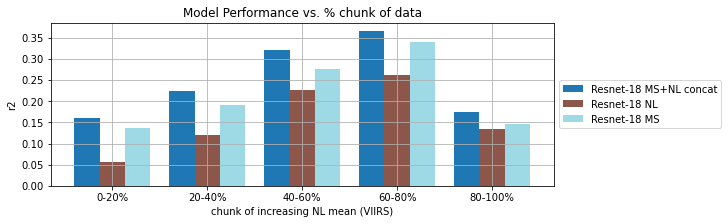

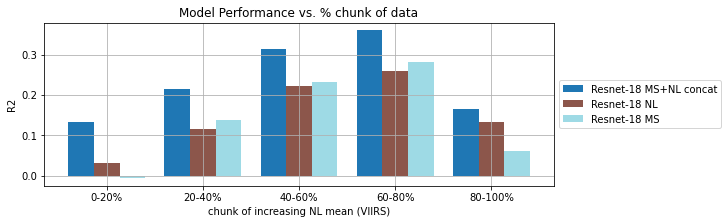

In [39]:
dmsp_mask = years < 2012
viirs_mask = ~dmsp_mask

for name, mask in [('DMSP', dmsp_mask), ('VIIRS', viirs_mask)]:
    chunk_r2s = np.zeros([len(model_names_by_mse), 5])
    chunk_R2s = np.zeros([len(model_names_by_mse), 5])
    for i, model_name in enumerate(model_names_by_mse):
        chunk_r2s[i, :] = chunk_vs_score(labels=labels[mask], preds=preds[model_name][mask], nchunks=5,
                                         metric='r2', chunk_value=nls_mean[mask])
        chunk_R2s[i, :] = chunk_vs_score(labels=labels[mask], preds=preds[model_name][mask], nchunks=5,
                                         metric='R2', chunk_value=nls_mean[mask])

    plot_chunk_vs_score(scores=chunk_r2s, legends=overall_df.index, metric='r2',
                        figsize=(10, 3), cmap='tab20', xlabel=f'chunk of increasing NL mean ({name})')
    plot_chunk_vs_score(scores=chunk_R2s, legends=overall_df.index, metric='R2',
                        figsize=(10, 3), cmap='tab20', xlabel=f'chunk of increasing NL mean ({name})')

In [40]:
cumulative_r2s = np.zeros([len(model_names_by_mse), num_examples])

for i, model_name in enumerate(model_names_by_mse):
    r2s, labels_sorted = sorted_scores(
        preds=preds[model_name], labels=labels, metric='R2', sort='increasing')
    cumulative_r2s[i, :] = r2s

/hdd/home/abenabbes/.conda/envs/py24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/hdd/home/abenabbes/.conda/envs/py24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/hdd/home/abenabbes/.conda/envs/py24/lib/python3.7/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [41]:
cumulative_r2_df = pd.DataFrame(
    data=cumulative_r2s.T,
    index=pd.Index(np.sort(labels), name='wealthpooled'),
    columns=model_names_by_mse)
with pd.option_context('display.max_rows', 20):
    display(cumulative_r2_df)

cumulative_r2_df.to_csv('dhs_incountry_cumulative_r2.csv', index=True)

,Resnet-18 MS+NL concat,Resnet-18 NL,Resnet-18 MS
wealthpooled,,,
-2.163420,NaN,NaN,NaN
-2.095903,-3498.350748,-2670.693535,-3920.172167
-1.885417,-274.096304,-209.489407,-311.761213
-1.883128,-245.861929,-184.153189,-287.049173
-1.787066,-182.457921,-135.360704,-210.807593
...,...,...,...
2.547635,0.689748,0.650748,0.648583
2.604293,0.689434,0.650437,0.648307
2.617261,0.689333,0.650288,0.648225


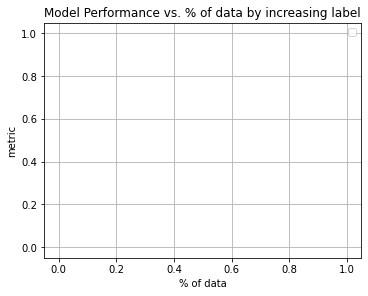

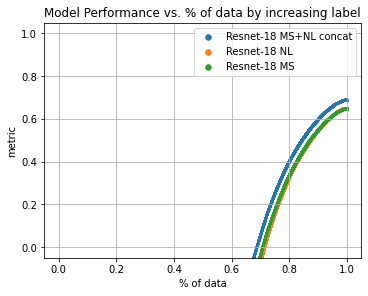

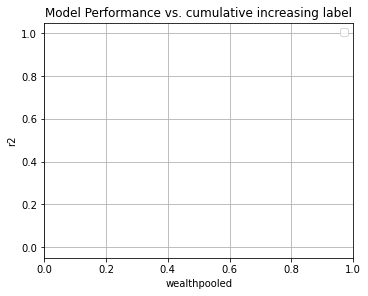

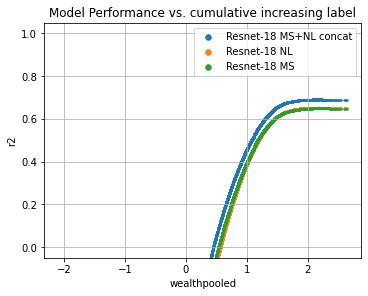

In [42]:
plot_percdata_vs_score(
    scores_list=cumulative_r2s[ridge_model_indices],
    legends=ridge_model_names,
    metric='r2',
    sort='increasing')

plot_percdata_vs_score(
    scores_list=cumulative_r2s[resnet_model_indices],
    legends=resnet_model_names,
    metric='r2',
    sort='increasing')

plot_label_vs_score(
    scores_list=cumulative_r2s[ridge_model_indices],
    labels_list=[np.sort(labels)] * len(ridge_model_indices),
    legends=ridge_model_names,
    metric='r2',
    sort='increasing')

plot_label_vs_score(
    scores_list=cumulative_r2s[resnet_model_indices],
    labels_list=[np.sort(labels)] * len(resnet_model_indices),
    legends=resnet_model_names,
    metric='r2',
    sort='increasing')

# Break-down by country, urban/rural

In [43]:
country_df = (
    preds_df
    .groupby('country')
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))

country_urban_df = (
    preds_df
    .groupby(['country', 'urban'])
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))







with pd.option_context('display.max_rows', 4, 'display.precision', 3):
    display(country_df)
    display(country_urban_df)
    
country_df.to_csv('temp_a.csv')#for personal checking

country_urban_df.to_csv('temp_b.csv') #for personal checking


r2     R2    mse   rank
country  model                                             
angola   Resnet-18 MS            0.762  0.731  0.314  0.837
         Resnet-18 MS+NL concat  0.780  0.733  0.311  0.852
...                                ...    ...    ...    ...
zimbabwe Resnet-18 MS+NL concat  0.773  0.685  0.276  0.798
         Resnet-18 NL            0.785  0.729  0.238  0.802

[75 rows x 4 columns]

r2     R2    mse   rank
country  urban model                                             
angola   False Resnet-18 MS            0.269 -0.219  0.300  0.338
               Resnet-18 MS+NL concat  0.309 -0.207  0.297  0.362
...                                      ...    ...    ...    ...
zimbabwe True  Resnet-18 MS+NL concat  0.140 -1.669  0.423  0.306
               Resnet-18 NL            0.137 -1.179  0.346  0.330

[150 rows x 4 columns]

# $r^2$ over all countries

In [ ]:
# get mean and median r^2 across countries
country_r2_df = country_df['r2'].unstack('model')
colordisplay(country_r2_df.describe().T)

print('urban:')
colordisplay(country_urban_df['r2'].unstack('model').loc[(slice(None), True), :].describe().T)

print('rural:')
colordisplay(country_urban_df['r2'].unstack('model').loc[(slice(None), False), :].describe().T)

In [ ]:
def weighted_r2(x):
    '''
    Args
    - x: pd.Series, index is (country, metric), value is score

    Returns:
    - y: float
    '''
    y = np.sum([
        x[country] * len(country_indices[country]) / len(labels)
        for country in x.index.get_level_values(0)
    ])
    return y

median_r2s = country_r2_df.median(axis=0).rename('median r2')
mean_r2s = country_r2_df.mean(axis=0).rename('mean r2')
weighted_r2s = country_r2_df.apply(weighted_r2, axis=0).rename('weighted r2')
overall_r2s = overall_df.loc[MODEL_NAMES, 'r2'].rename('overall r2')

agg_r2s = pd.concat([weighted_r2s, median_r2s, mean_r2s, overall_r2s], axis=1)
agg_r2s.sort_values(by='weighted r2', ascending=False, inplace=True)
colordisplay(agg_r2s)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
agg_r2s.T.plot(kind='bar', ax=ax, width=0.9, colormap='tab20')
plt.setp(ax.get_xticklabels(), rotation=0, ha='center',
         rotation_mode='anchor')
ax.set_ylabel('r^2')
ax.set_title('Incountry r^2 on test countries')
ax.grid(True, axis='y')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

In [ ]:
def plot_country_performance(df, model_names, title, xlabel):
    '''
    Args
    - df: pd.DataFrame, df.loc[country, model_name] gives model performance on a particular country
    - model_names: list of str
    - title: str
    - xlabel: str
    '''
    CMAP_FN = plt.cm.get_cmap('tab20')
    COUNTRY_YEAR_COLORS = [CMAP_FN.colors[i % 20] for i in range(len(countries))]

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    for i, country in enumerate(countries):
        r2s = df.loc[country, model_names]
        size = len(country_indices[country]) / len(labels) * 1000
        ax.scatter(x=r2s, y=model_names, s=size, c=[COUNTRY_YEAR_COLORS[i]], label=country)

    ax.invert_yaxis()  # invert direction to put best-performing models at the top
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.show()

plot_country_performance(
    df=country_r2_df,
    model_names=list(agg_r2s.index),
    title='Incountry Test Performance',
    xlabel='test r^2')

# Break-down by country-year, urban/rural

In [ ]:
countryyear_df = (
    preds_df
    .groupby(['country', 'year'])
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))
countryyear_urban_df = (
    preds_df
    .groupby(['country', 'year', 'urban'])
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))

with pd.option_context('display.max_rows', 4, 'display.precision', 3):
    display(countryyear_df)
    display(countryyear_urban_df)

In [ ]:
# get mean and median r^2 across country_years
countryyear_r2_df = countryyear_df['r2'].unstack('model')
colordisplay(countryyear_r2_df.describe().T)

print('urban:')
colordisplay(countryyear_urban_df['r2'].unstack('model').loc[(slice(None), slice(None), True), :].describe().T)

print('rural:')
colordisplay(countryyear_urban_df['r2'].unstack('model').loc[(slice(None), slice(None), False), :].describe().T)

# Urban/rural

In [ ]:
urban_rural_df = (
    preds_df
    .groupby('urban')
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model')
    .unstack('urban'))

with pd.option_context('display.max_rows', 20, 'display.precision', 3):
    display(urban_rural_df)

In [ ]:
ax = urban_rural_df.loc[:, ('r2', slice(None))].plot(
    kind='bar', figsize=[10, 5])
ax.set_ylabel('test $r^2$ on urban/rural')
ax.set_ylim(bottom=0, top=0.7)
ax.set_title('Model performance ($r^2$) on urban vs. rural')
ax.grid(True, axis='y')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=60, ha='right',
         rotation_mode='anchor')
plt.tight_layout()
plt.show()

In [ ]:
ax = urban_rural_df.loc[:, ('R2', slice(None))].plot(
    kind='bar', figsize=[10, 5])
ax.set_ylabel('test $R^2$ on urban/rural')
ax.set_ylim(bottom=0, top=0.8)
ax.set_title('Model performance ($R^2$) on urban vs. rural')
ax.grid(True, axis='y')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=60, ha='right',
         rotation_mode='anchor')
plt.tight_layout()
plt.show()

In [ ]:
def plot_urban_rural_predictions(labels, preds, urban_indices, rural_indices):
    '''
    Args
    - labels: np.array, shape [N]
    - preds: dict, model_name => np.array, shape [N]
    - urban_indices: np.array, shape [num_urban]
    - rural_indices: np.array, shape [num_rural]
    '''
    nrows = int(np.ceil(np.sqrt(len(preds))))
    ncols = int(np.ceil(len(preds) / nrows))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                            sharey=False, sharex=False, figsize=[ncols*3, nrows*3])
    for model_name, ax in zip(preds, axs.flat):
        ax.scatter(
            x=labels[urban_indices],
            y=preds[model_name][urban_indices],
            s=2, label='urban')
        ax.scatter(
            x=labels[rural_indices],
            y=preds[model_name][rural_indices],
            s=2, label='rural')
        ax.grid(True)
        ax.set_aspect('equal')
        ax.set(xlabel='label', ylabel='pred', title=model_name)
        xy_line = np.array([-2, 3])
        ax.plot(xy_line, xy_line, color='black')
        ax.legend()
    fig.tight_layout()
    plt.show()

plot_urban_rural_predictions(labels, preds, urban_indices, rural_indices)

## By Country

In [ ]:
plot_country_performance(
    df=country_urban_df['r2'].unstack('model').loc[(slice(None), True), :],
    model_names=MODEL_NAMES,
    title='Incountry Test Performance on Urban',
    xlabel='test $r^2$')

plot_country_performance(
    df=country_urban_df['r2'].unstack('model').loc[(slice(None), False), :],
    model_names=MODEL_NAMES,
    title='Incountry Test Performance on Rural',
    xlabel='test $r^2$')

# Model performance as function of NL

## When NL = 0

In [ ]:
from batchers.batcher import MEANS_DICT, STD_DEVS_DICT

dmsp0 = (0.0 - MEANS_DICT[DATASET_NAME]['DMSP']) / STD_DEVS_DICT[DATASET_NAME]['DMSP']
viirs0 = (0.0 - MEANS_DICT[DATASET_NAME]['VIIRS']) / STD_DEVS_DICT[DATASET_NAME]['VIIRS']

print('DMSP 0-value (after normalization):', dmsp0)
print('VIIRS 0-value (after normalization):', viirs0)

dmsp0_indices = (years < 2012) & (nls_mean == dmsp0)
viirs0_indices = (years >= 2012) & (nls_mean == viirs0)
nl0_indices = dmsp0_indices | viirs0_indices

assert np.all(nls_mean[nl0_indices] == dmsp0)
assert np.all(nls_center[nl0_indices] == dmsp0)

In [ ]:
print('# of locs w/ DMSP=0:', np.sum(dmsp0_indices))
print('# of locs w/ VIIRS=0:', np.sum(viirs0_indices))
print('# of locs w/ NL=0:', np.sum(nl0_indices))

Because we train a separate ridge regression model for each left-out test country, we get many different predictions for when NL = 0.

In [ ]:
# np.unique(preds['Resnet-18 NL'][nl0_indices])

In [ ]:
def plot_preds_nl0(model_name, labels, preds, nl0_indices):
    '''
    Args
    - model_name: str
    - labels: np.array, shape [num_examples]
    - preds: np.array, shape [num_examples]
    - nl0_indices: np.array, integer indices into labels/preds
    '''
    fig, ax = plt.subplots(1, 1, figsize=[4, 4])
    ax.scatter(x=labels, y=preds, s=2)
    ax.scatter(x=labels[nl0_indices], y=preds[nl0_indices], c='red', s=2, label='NL = 0')
    ax.set(xlabel='label', ylabel='pred', title=model_name)
    ax.grid(True)
    ax.set_aspect('equal')
    xy_line = np.array([-1.5, 3])
    ax.plot(xy_line, xy_line, color='black')
    ax.legend()
    fig.tight_layout()
    plt.show()

for model_name in MODEL_NAME_TO_DIR:
    plot_preds_nl0(model_name, labels, preds[model_name], nl0_indices)

In [ ]:
nl0_df = evaluate_df(preds_df.loc[nl0_indices, :], cols=MODEL_NAMES)
nl0_df.sort_values('r2', ascending=False, inplace=True)
display(nl0_df.style.format('{:.3f}'))

## Predictions vs. NL mean

In [ ]:
def plot_preds_v_nl(model_name, preds, nl_means):
    '''
    Args
    - model_name: str
    - preds: np.array
    - nl_means: np.array
    '''
    fig, ax = plt.subplots(1, 1, figsize=[5, 5])
    ax.scatter(x=nl_means, y=preds, s=3)
    ax.set_title(model_name)
    ax.set_xlabel('Mean NL of Image (std dev from mean)')
    ax.set_ylabel('Predicted Wealthpooled')
    ax.grid(True)
    fig.tight_layout()
    plt.show()

def plot_residuals_v_nl(model_name, preds, labels, nl_means):
    '''
    Args
    - model_name: str
    - preds: np.array
    - labels: np.array
    - nl_means: np.array
    '''
    residuals = labels - preds
    fig, ax = plt.subplots(1, 1, figsize=[5, 5])
    ax.scatter(x=nl_means, y=residuals, s=3)
    ax.set_title(model_name)
    ax.set_xlabel('Mean NL of Image (std dev from mean)')
    ax.set_ylabel('Residual (label - pred)')
    ax.grid(True)
    fig.tight_layout()
    plt.show()

In [ ]:
for model_name in MODEL_NAME_TO_DIR:
    plot_preds_v_nl(model_name, preds[model_name], nls_mean)

In [ ]:
for model_name in MODEL_NAME_TO_DIR:
    plot_residuals_v_nl(model_name, preds[model_name], labels, nls_mean)